## Attention weight visualiation of pre-trained Vision Transformer

In [30]:
## Imports
import torch
import torchvision.transforms as transforms
from torchvision.models.vision_transformer import vit_b_16
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import cv2

In [31]:
# Load Pretrained Vision Transformer Model
model = vit_b_16(pretrained=True)
model.eval()

# Preprocessing Function
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to Extract Attention Maps from Encoder and Decoder
def get_attention_maps(model, image):
    with torch.no_grad():
        x = model.conv_proj(image)  # Convert image to patches
        x = x.flatten(2).transpose(1, 2)  # (Batch, Tokens, Embedding)
        cls_token = model.class_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + model.encoder.pos_embedding

        encoder_attentions = []
        for layer in model.encoder.layers:
            attn_output = layer.ln_1(x)
            _, attn_weights = layer.self_attention(attn_output, attn_output, attn_output)
            attn_weights = attn_weights.mean(dim=1)  # Average across attention heads
            attn_weights = (attn_weights - attn_weights.min()) / (attn_weights.max() - attn_weights.min())  # Normalize for better contrast
            encoder_attentions.append(attn_weights)
            x = layer(x)

    return encoder_attentions

In [32]:
# Function to Superimpose Attention Maps on Input Image
def overlay_attention(image_path, attention_maps, alpha=0.4):
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (224, 224))

    num_layers = len(attention_maps)
    fig, axes = plt.subplots(1, num_layers, figsize=(20, 5))

    for i, attn in enumerate(attention_maps):
        attn = attn[0, 1:].cpu().numpy()  # Remove CLS token attention
        num_patches = attn.shape[0]
        patch_dim = int(np.sqrt(num_patches))
        attn = attn.reshape(patch_dim, patch_dim)

        attn_resized = cv2.resize(attn, (224, 224))
        attn_resized = (attn_resized * 255).astype(np.uint8)  # Enhance visibility
        heatmap = cv2.applyColorMap(attn_resized, cv2.COLORMAP_JET)
        heatmap = cv2.GaussianBlur(heatmap, (11, 11), 0)  # Apply smoothing for clarity
        overlay = cv2.addWeighted(original_image, alpha, heatmap, 1 - alpha, 0)

        axes[i].imshow(overlay[:, :, ::-1])  # Convert BGR to RGB for Matplotlib
        axes[i].set_title(f'Layer {i+1}', fontsize=14, fontweight="bold")
        axes[i].axis("off")

    plt.show()


Before visualizing attention weights, please follow the link below to download the image. You can also your any other image.

link: https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Sunflower_from_Silesia2.jpg/800px-Sunflower_from_Silesia2.jpg

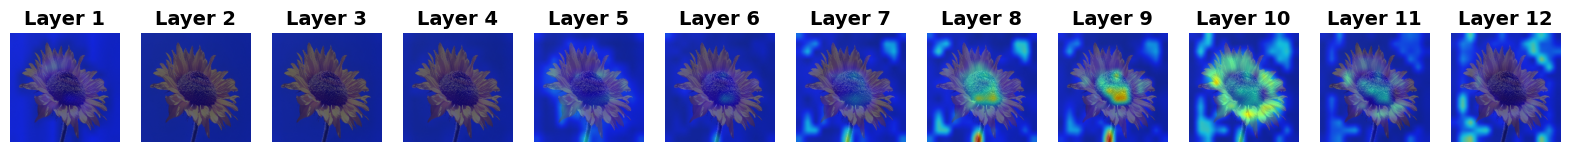

In [34]:
# Example Usage
image_path = "/content/flower.jpg"  # Example image URL, change if needed!!
image = preprocess_image(image_path)
attention_maps = get_attention_maps(model, image)
overlay_attention(image_path, attention_maps)